<a href="https://colab.research.google.com/github/eemeidinger/loopy_copy/blob/main/loopy_copy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from collections import OrderedDict

# In[deskew]:
def deskew(img):
    thresh=img
    edges = cv2.Canny(thresh,50,200,apertureSize = 3)

    lines = cv2.HoughLines(edges,1,np.pi/1000, 55)
    try:
        d1 = OrderedDict()
        for i in range(len(lines)):
            for rho,theta in lines[i]:
                deg = np.rad2deg(theta)
#                print(deg)
                if deg in d1:
                    d1[deg] += 1
                else:
                    d1[deg] = 1

        t1 = OrderedDict(sorted(d1.items(), key=lambda x:x[1] , reverse=False))
        print(list(t1.keys())[0],'Angle' ,thresh.shape)
        non_zero_pixels = cv2.findNonZero(thresh)
        center, wh, theta = cv2.minAreaRect(non_zero_pixels)
        angle=list(t1.keys())[0]
        if angle>160:
            angle=180-angle
        if angle<160 and angle>20:
            angle=12
        root_mat = cv2.getRotationMatrix2D(center, angle, 1)
        rows, cols = img.shape
        rotated = cv2.warpAffine(img, root_mat, (cols, rows), flags=cv2.INTER_CUBIC)

    except:
        rotated=img
        pass
    return rotated

def unshear(img):

    gray = img
    thresh = img.copy()
    #print(thresh)
    plt.imshow(thresh)
    plt.show()
    trans = thresh.transpose()

    arr=[]
    for i in range(thresh.shape[1]):
        arr.insert(0,trans[i].sum())

    arr=[]
    for i in range(thresh.shape[0]):
        arr.insert(0,thresh[i].sum())

    y = thresh.shape[0]-1-np.nonzero(arr)[0][0]
    y_top = thresh.shape[0]-1-np.nonzero(arr)[0][-1]

    trans1 = thresh.transpose()
    sum1=[]
    for i in range(trans1.shape[0]):
        sum1.insert(i,trans1[i].sum())

    height = y - y_top
    max_value = 255*height
    prev_num = len([i for i in sum1 if i>=(0.6*max_value)])
    final_ang = 0

    # # print(arr)
    # # print(x,y)
    for ang in range(-25,25,3):
        thresh = gray.copy()
        #print(thresh[0].shape)
        #print(ang)
        print('Ang',ang)
        if ang>0:
            #print(ang)
            for i in range(y):
                temp = thresh[i]
                move = int((y-i)*(math.tan(math.radians(ang))))
                if move >= temp.size:
                    move = temp.size
                thresh[i][:temp.size-move]=temp[move:]
                thresh[i][temp.size-move:] = [0 for m in range(move)]
        else:
            #print(ang)
            for i in range(y):
                temp = thresh[i]
                move = int((y-i)*(math.tan(math.radians(-ang))))
                if move >= temp.size:
                    move = temp.size
                #print(temp[:-3])
                #print(temp[:temp.size-move].shape, thresh[i][move%temp.size:].shape)
                thresh[i][move:]=temp[:temp.size-move]
                thresh[i][:move]=[0 for m in range(move)]

#         plt.imshow(thresh)
#         plt.show()
        trans1 = thresh.transpose()
        sum1=[]
        for i in range(trans1.shape[0]):
            sum1.insert(i,trans1[i].sum())
        #print(sum1)
        num = len([i for i in sum1 if i>=(0.60*max_value)])
        #print(num, prev_num)
        if(num>=prev_num):
            prev_num=num
            final_ang = ang
        #plt.imshow(thresh)
        #plt.show()
    #print("final_ang:", final_ang)

    thresh= gray.copy()
    if final_ang>0:
        for i in range(y):
            temp = thresh[i]
            move = int((y-i)*(math.tan(math.radians(final_ang))))
            if move >= temp.size:
                move = temp.size
            thresh[i][:temp.size-move]=temp[move:]
            thresh[i][temp.size-move:] = [0 for m in range(move)]
    else:
        for i in range(y):
            temp = thresh[i]
            move = int((y-i)*(math.tan(math.radians(-final_ang))))
            #print(move)
            if move >= temp.size:
                move = temp.size
            thresh[i][move:]=temp[:temp.size-move]
            thresh[i][:move]=[0 for m in range(move)]

    plt.imshow(thresh, cmap='gray_r')
#    plt.show()
    return thresh


# In[Main]:

# def pad_with(vector, pad_width, iaxis, kwargs):
#      pad_value = kwargs.get('padder', 40)
#      vector[:pad_width[0]] = pad_value
#      vector[-pad_width[1]:] = pad_value
#      return vector

In [ ]:
import numpy as np
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00


In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image as image_tf
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from skimage import color, data, filters, graph, measure, morphology,io
from skimage.filters import threshold_otsu,threshold_li
import cv2

In [ ]:
img = cv2.imread('example_crop_1746.png')

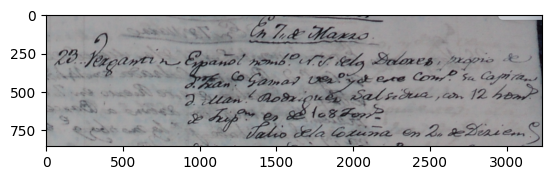

In [ ]:
plt.imshow(img)

In [ ]:
def image_processer(img):
  retina = img
  retina = color.rgb2gray(retina)
  t0,t1,t2,t3,t4 = filters.threshold_multiotsu(retina, classes=6)

  mask = (retina < t0)
  vessels = filters.sato(retina, sigmas=range(1, 10)) * mask
  thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)
  labeled = ndi.label(thresholded)[0]
  _, ax = plt.subplots()
  ax.imshow(color.label2rgb(labeled, retina))

  thresh = threshold_otsu(retina)
  binary = thresh > retina
  binary = unshear(binary * 255)
  plt.savefig('processed_image')
  return binary

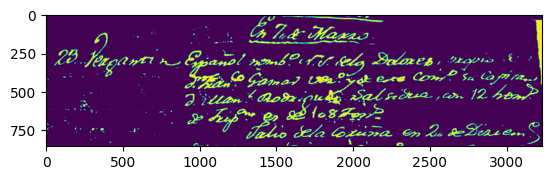

Ang -25
Ang -22
Ang -19
Ang -16
Ang -13
Ang -10
Ang -7
Ang -4
Ang -1
Ang 2
Ang 5
Ang 8
Ang 11
Ang 14
Ang 17
Ang 20
Ang 23


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

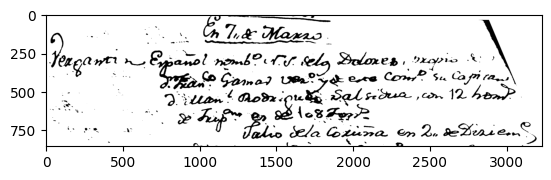

In [ ]:
image_processer(img)

In [ ]:
img2 = cv2.imread('processed_image.png')

In [ ]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
img2 = imutils.resize(img2, height=2000)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 20, 170, 255)

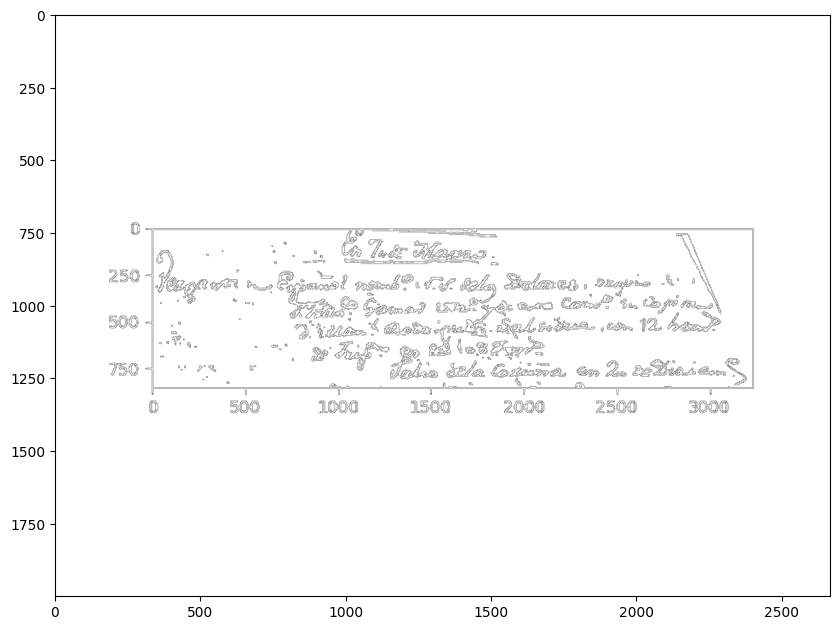

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(abs(edged-255),cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import cv2
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=False,
                 	default="drive/MyDrive/Global_Americas/processed_image/processed_image.png", help = 'path to input image')
ap.add_argument("-c", "--connectivity", type=int, default=4,
	help="connectivity for connected component analysis")
ap.add_argument("-f", required=False)
args = vars(ap.parse_args())

In [ ]:
#convert the image to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [ ]:
# apply connected component analysis to the thresholded image
output = cv2.connectedComponentsWithStats(
	thresh, args["connectivity"], cv2.CV_32S)
(numLabels, labels, stats, centroids) = output

In [ ]:
# loop over the number of unique connected component labels
for i in range(0, numLabels):
	# if this is the first component then we examine the
	# *background* (typically we would just ignore this
	# component in our loop)
	if i == 0:
		text = "examining component {}/{} (background)".format(
			i + 1, numLabels)
	# otherwise, we are examining an actual connected component
	else:
		text = "examining component {}/{}".format( i + 1, numLabels)
	# print a status message update for the current connected
	# component
	print("[INFO] {}".format(text))
	# extract the connected component statistics and centroid for
	# the current label
	x = stats[i, cv2.CC_STAT_LEFT]
	y = stats[i, cv2.CC_STAT_TOP]
	w = stats[i, cv2.CC_STAT_WIDTH]
	h = stats[i, cv2.CC_STAT_HEIGHT]
	area = stats[i, cv2.CC_STAT_AREA]
	(cX, cY) = centroids[i]

[INFO] examining component 1/228 (background)
[INFO] examining component 2/228
[INFO] examining component 3/228
[INFO] examining component 4/228
[INFO] examining component 5/228
[INFO] examining component 6/228
[INFO] examining component 7/228
[INFO] examining component 8/228
[INFO] examining component 9/228
[INFO] examining component 10/228
[INFO] examining component 11/228
[INFO] examining component 12/228
[INFO] examining component 13/228
[INFO] examining component 14/228
[INFO] examining component 15/228
[INFO] examining component 16/228
[INFO] examining component 17/228
[INFO] examining component 18/228
[INFO] examining component 19/228
[INFO] examining component 20/228
[INFO] examining component 21/228
[INFO] examining component 22/228
[INFO] examining component 23/228
[INFO] examining component 24/228
[INFO] examining component 25/228
[INFO] examining component 26/228
[INFO] examining component 27/228
[INFO] examining component 28/228
[INFO] examining component 29/228
[INFO] exa

In [ ]:
	# clone our original image (so we can draw on it) and then draw
	# a bounding box surrounding the connected component along with
	# a circle corresponding to the centroid
	output = image.copy()
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
	cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

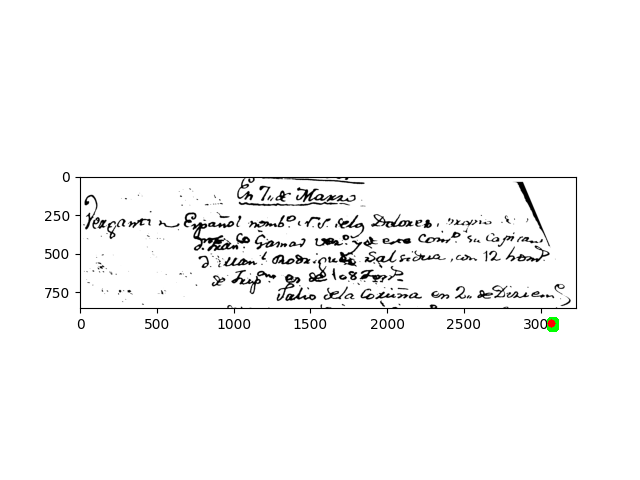

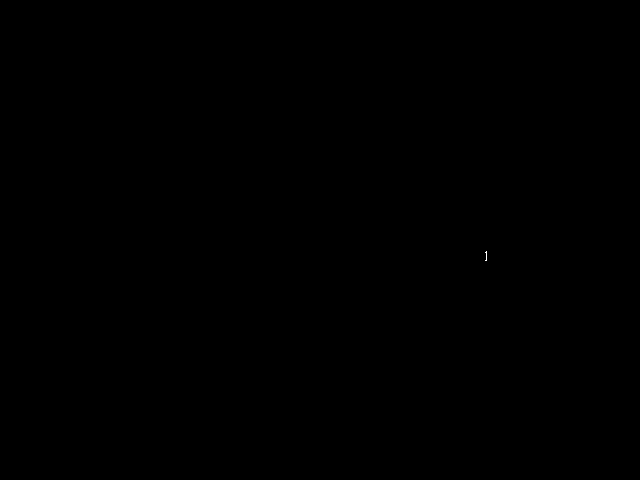

-1

In [ ]:
# construct a mask for the current connected component by
# finding a pixels in the labels array that have the current
# connected component ID
from google.colab.patches import cv2_imshow
#the labels is an arbitrary connected component
componentMask = (labels == 110).astype("uint8") * 255
# show our output image and connected component mask
#output
cv2_imshow(output)
#connected component
cv2_imshow(componentMask)
cv2.waitKey(0)

In [ ]:
#identify network design
#bnn activation functions determine conditional probability values p(theta | data)
#you want to maximize likelihood and create a prior
#reshape individual images to a specific size